In [1]:
import numpy as np
import matplotlib.pyplot as plt

import histlite as hl
import astropy
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u

In [2]:
from nsb.atmosphere import scattering, extinction

from nsb.emitter import moon, stars, airglow, galactic, zodiacal
import nsb.utils.plots as uplot

from nsb.core.logic import Layer, Scattering
from nsb.core import Frame, Model
from nsb.core.emitter import Emitter
from nsb.core.instrument import Instrument, Camera, Pixel
from nsb.core.ray import Ray
from nsb.core.utils import reduce_rays, haversine, hist_sample
import nsb.utils.bandpass as bandpass

In [3]:
%load_ext snakeviz
%snakeviz_config -h localhost -p 31159

Snakeviz configured with host localhost and port 31159


# Predicting Night Sky Background for H.E.S.S.

## 1. Configuring the model layers:

Configuring the models for emitters:

In [4]:
# Moonlight:
conf_jons = {}

# Diffuse Emitters:
conf_glow = {"H": 87}
conf_hmag  = {"Mag_0": 236.8*2.3504*1e-11}
conf_kawa = {'i100_max':50, 'star_percentage':0.25}

# Starlight
conf_gaia = {"catalog_file": '/lfs/l7/hess/users/gerritr/GaiaDR3Tycho.pkl', "magmin" : -2, "magmax": 15}

Configuring atmospheric scattering:

In [5]:
conf_mie = {"parameters": [0.8],
            "bins": [np.linspace(0, np.pi, 1000)]}      
conf_ray = {"parameters": [0.0148],
            "bins": [np.linspace(0, np.pi, 1000)]}

Creating the Instrument from ctapipe & simplified psf:

In [6]:
from ctapipe.instrument import CameraGeometry
c_bins = [np.linspace(0, np.deg2rad(3.5), 50), np.linspace(0, 2*np.pi, 20), np.linspace(0, 2*1e-3, 100)]

def psf(off, pos, rho):
    p = [0.12, 0.5]
    off = off/np.deg2rad(2.5)
    
    sigma = np.sqrt(p[0]**2 + p[1]*off**2)*1e-3
    
    return np.sin(rho)/(2*np.pi*sigma**2) * np.exp(-rho**2/(2*sigma**2))

h_psf = hl.hist_from_eval(psf, bins=c_bins)
cam = CameraGeometry.from_name('HESS-I')
hess1u = Camera.from_ctapipe(cam, h_psf, 94.4, 15.28)

## 2. Creating a model:
### Defining simple model including Moon, Stars and Airglow:

In [7]:
# Sources:
glow = airglow.Noll2012(conf_glow)
zodi = zodiacal.Masana2021({})

gaia = stars.StarCatalog(conf_gaia)
hmag = galactic.GaiaDR3Mag15(conf_hmag)
gbl  = galactic.Kawara2017(conf_kawa)

jons = moon.Jones2013(conf_jons)

# Atmospheric Extinction:
atm_airglow = extinction.Noll2012({'scale':1.6, 'offset':-0.16})([glow])
atm_diffuse = extinction.Masana2021({'gamma':0.5})([zodi, gbl])
atm_stellar = extinction.Masana2021({'gamma':1})([gaia, hmag])

# Atmospheric Scattering:
atm_ray = scattering.Rayleigh(conf_ray)([jons]).map(np.deg2rad(180))
atm_mie = scattering.Mie(conf_mie)([jons]).map(np.deg2rad(180))

# Testing scattering components
atm_tes = scattering.Mie(conf_mie, N=50)([glow, zodi, gbl])
atm_tet = scattering.Rayleigh(conf_ray, N=50)([glow, zodi, gbl])

# Camera:
CT1 = Instrument({'camera':hess1u, 'bandpass':bandpass.HESS1U()}, 1)([atm_stellar, atm_ray, atm_mie, atm_tes, atm_tet])

### Compiling the model:

In [8]:
%%time
model = Model(CT1)
model.compile()

CPU times: user 3.35 s, sys: 11.8 s, total: 15.1 s
Wall time: 17.9 s


### Visualizing the pipeline

In [9]:
print(model.summary())

defaultdict(<class 'list'>, {<nsb.core.instrument.Instrument object at 0x7fcef5bb1550>: [<nsb.atmosphere.extinction.Masana2021 object at 0x7fcef53b3c50>, <nsb.atmosphere.scattering.Rayleigh object at 0x7fcef53b76d0>, <nsb.atmosphere.scattering.Mie object at 0x7fcf7534aed0>, <nsb.atmosphere.scattering.Mie object at 0x7fcef57406d0>, <nsb.atmosphere.scattering.Rayleigh object at 0x7fcef5740750>], <nsb.atmosphere.extinction.Masana2021 object at 0x7fcef53b3c50>: [<nsb.emitter.stars.StarCatalog object at 0x7fcef5bd3c50>, <nsb.emitter.galactic.GaiaDR3Mag15 object at 0x7fcef6596bd0>], <nsb.atmosphere.scattering.Rayleigh object at 0x7fcef53b76d0>: [<nsb.emitter.moon.Jones2013 object at 0x7fcef5beb8d0>], <nsb.atmosphere.scattering.Mie object at 0x7fcf7534aed0>: [<nsb.emitter.moon.Jones2013 object at 0x7fcef5beb8d0>], <nsb.atmosphere.scattering.Mie object at 0x7fcef57406d0>: [<nsb.emitter.airglow.Noll2012 object at 0x7fcef5753d90>, <nsb.emitter.zodiacal.Masana2021 object at 0x7fcef5753dd0>, <nsb.

## 3. Determining a frame to capture:
A "frame" describing a capture is determined by:
 - A location
 - An observation time in UTC
 - A target at which to point

In [10]:
location = EarthLocation.from_geodetic(16.5028, -23.27280, 1800.)
obstime  = astropy.time.Time('2021-03-21T22:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('eta car')

frame = Frame(location, obstime, target, 3.2, -0.25*u.deg, np.linspace(270, 730, 30)*u.nm, albedo=0.85, aero=[0.065, 1.2], sfu=75)

## 4. Using the model to predict NSB

In [11]:
%%time
res = model.predict(frame)

CPU times: user 1.16 s, sys: 1.46 s, total: 2.62 s
Wall time: 2.65 s


## 5. Visualizing the data:
Each pipeline layer has it's corresponding visualization. It can either be called on a frame or rays generated by the same layer. As such, the final data can be easily evaluated:

In [12]:
from ctapipe.visualization import CameraDisplay
def ctapipe_disp(cam, instrument, rays, ax, label='a.u.', **kwargs):
    display = CameraDisplay(cam, ax=ax, **kwargs)
    display.image = instrument.camera.pix_assign(rays)
    display.add_colorbar(label=label)
    return display

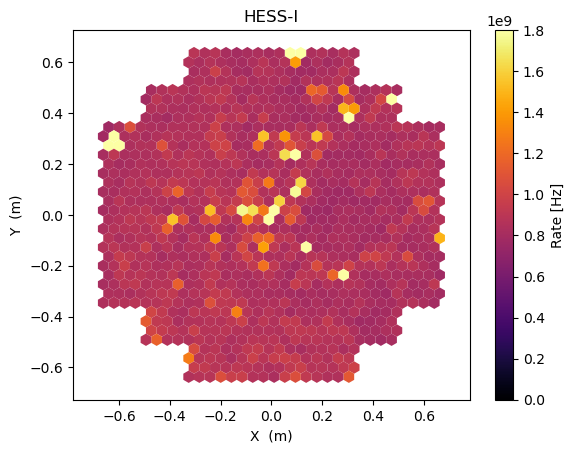

In [13]:
fig, ax = plt.subplots()
disp = ctapipe_disp(cam, CT1, res, ax, 'Rate [Hz]', show_frame=False)
disp.set_limits_minmax(0, 1.8e9)

### Individual contributions:

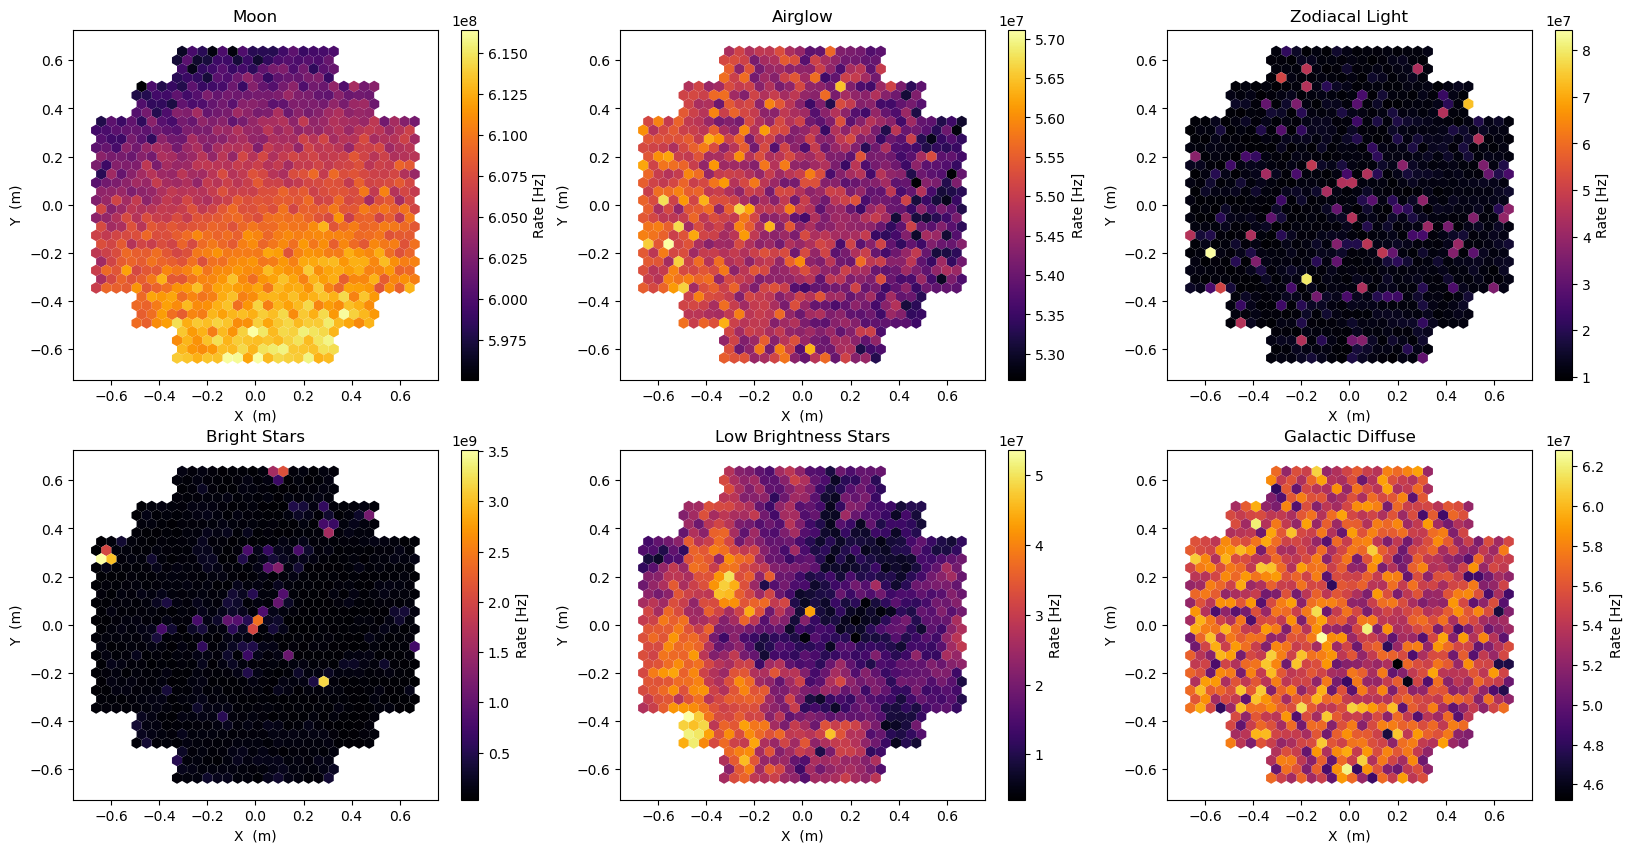

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
disp1 = ctapipe_disp(cam, CT1, res[res.source == type(jons)], ax[0,0], 'Rate [Hz]', title='Moon', show_frame=False)
disp2 = ctapipe_disp(cam, CT1, res[res.source == type(glow)], ax[0,1], 'Rate [Hz]', title='Airglow', show_frame=False)
disp3 = ctapipe_disp(cam, CT1, res[res.source == type(zodi)], ax[0,2], 'Rate [Hz]', title='Zodiacal Light', show_frame=False)
disp4 = ctapipe_disp(cam, CT1, res[res.source == type(gaia)], ax[1,0], 'Rate [Hz]', title='Bright Stars', show_frame=False)
disp5 = ctapipe_disp(cam, CT1, res[res.source == type(hmag)], ax[1,1], 'Rate [Hz]', title='Low Brightness Stars', show_frame=False)
disp6 = ctapipe_disp(cam, CT1, res[res.source == type(gbl)], ax[1,2], 'Rate [Hz]', title='Galactic Diffuse', show_frame=False)